In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d coreylammie/deepweedsx

100% 940M/943M [00:42<00:00, 23.2MB/s]
100% 943M/943M [00:42<00:00, 23.0MB/s]


In [ ]:
! unzip \*zip

Output streaming troncato alle ultime 5000 righe.
  inflating: deepweeds_images_256/20180109-072555-1.jpg  
  inflating: deepweeds_images_256/20180109-072603-2.jpg  
  inflating: deepweeds_images_256/20180109-072606-1.jpg  
  inflating: deepweeds_images_256/20180109-072615-2.jpg  
  inflating: deepweeds_images_256/20180109-072622-1.jpg  
  inflating: deepweeds_images_256/20180109-072624-2.jpg  
  inflating: deepweeds_images_256/20180109-072632-1.jpg  
  inflating: deepweeds_images_256/20180109-072636-2.jpg  
  inflating: deepweeds_images_256/20180109-072643-2.jpg  
  inflating: deepweeds_images_256/20180109-072648-1.jpg  
  inflating: deepweeds_images_256/20180109-072650-2.jpg  
  inflating: deepweeds_images_256/20180109-072659-1.jpg  
  inflating: deepweeds_images_256/20180109-072659-2.jpg  
  inflating: deepweeds_images_256/20180109-072708-2.jpg  
  inflating: deepweeds_images_256/20180109-072712-1.jpg  
  inflating: deepweeds_images_256/20180109-072720-2.jpg  
  inflating: deepweeds

In [ ]:
train_dir = '/content/DeepWeeds_Images_256'
test_dir = '/content/deepweeds_images_256'

In [ ]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import cv2

In [ ]:
df = pd.read_csv('/content/train_set_labels.csv')

In [ ]:
df.head(5)

,Label,Species
0,20161207-111327-0.jpg,0
1,20170718-095159-2.jpg,0
2,20170811-133439-1.jpg,0
3,20170811-133752-1.jpg,0
4,20170217-114015-0.jpg,0


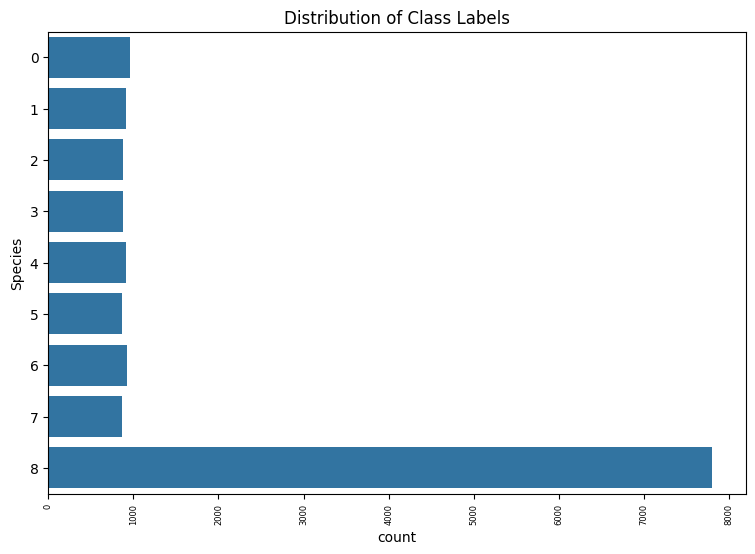

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns
plt.figure(figsize=(9,6))
sns.countplot(y='Species', data=df)
plt.title('Distribution of Class Labels')
plt.xticks(rotation=90, fontsize=6)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , BatchNormalization , Dropout , GlobalAveragePooling2D
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

In [ ]:
df['Species']=df['Species'].astype(str)
df

,Label,Species
0,20161207-111327-0.jpg,0
1,20170718-095159-2.jpg,0
2,20170811-133439-1.jpg,0
3,20170811-133752-1.jpg,0
4,20170217-114015-0.jpg,0
...,...,...
15002,20171205-133817-2.jpg,8
15003,20171205-141022-2.jpg,8
15004,20180322-112652-2.jpg,8
15005,20171212-100725-3.jpg,8


In [ ]:
training_set,validation_set= train_test_split(df, test_size=0.2 , random_state=0)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen= ImageDataGenerator(rescale=1./255,
                                 rotation_range=20,
                                 zoom_range=0.5,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)

validation_datagen=ImageDataGenerator(rescale=1./255)

train_generator= train_datagen.flow_from_dataframe(dataframe=training_set,directory='/content/deepweeds_images_256',x_col="Label",y_col="Species",
                                                   target_size=(224,224),batch_size=16,class_mode="categorical")

validation_generator= validation_datagen.flow_from_dataframe(dataframe=validation_set,directory='/content/deepweeds_images_256',x_col="Label",y_col="Species",
                                                   target_size=(224,224),batch_size=16,class_mode='categorical')

Found 12005 validated image filenames belonging to 9 classes.
Found 3002 validated image filenames belonging to 9 classes.


In [ ]:
image_size=160
IMG_SIZE=(224,224,3)

base_model=tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable=False



model=Sequential()
model.add(base_model)

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2),padding='same'))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2),padding='same'))


model.add(Flatten())

model.add(Dense(1024,activation='relu'))

model.add(Dense(512,activation='relu'))

model.add(Dense(256,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dense(32,activation='relu'))

model.add(Dense(9,activation='softmax'))


opt=keras.optimizers.Adam(learning_rate=0.001,epsilon=1e-07)
model.compile(optimizer="sgd",loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                      

In [ ]:
epochs=10
steps_per_epochs=165
validation_step=165
Callback= tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/output/kaggle/working',monitor='val_accuracy', verbose= 1 ,save_best_only=True,)

history=model.fit_generator(train_generator,epochs=epochs,
                            steps_per_epoch=steps_per_epochs,
                            validation_data=validation_generator,
                            validation_steps=validation_step,callbacks=[Callback])

<ipython-input-32-162269488f27>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator,epochs=epochs,


Epoch 1/10
165/165 [==============================] - ETA: 0s - loss: 1.6195 - accuracy: 0.5030
Epoch 1: val_accuracy improved from -inf to 0.52424, saving model to /kaggle/output/kaggle/working


165/165 [==============================] - 331s 2s/step - loss: 1.6195 - accuracy: 0.5030 - val_loss: 1.4697 - val_accuracy: 0.5242
Epoch 2/10
165/165 [==============================] - ETA: 0s - loss: 1.4262 - accuracy: 0.5216
Epoch 2: val_accuracy did not improve from 0.52424
165/165 [==============================] - 294s 2s/step - loss: 1.4262 - accuracy: 0.5216 - val_loss: 1.6248 - val_accuracy: 0.4356
Epoch 3/10
165/165 [==============================] - ETA: 0s - loss: 1.2837 - accuracy: 0.5602
Epoch 3: val_accuracy improved from 0.52424 to 0.55417, saving model to /kaggle/output/kaggle/working


165/165 [==============================] - 325s 2s/step - loss: 1.2837 - accuracy: 0.5602 - val_loss: 1.2372 - val_accuracy: 0.5542
Epoch 4/10
165/165 [==============================] - ETA: 0s - loss: 1.2459 - accuracy: 0.5648
Epoch 4: val_accuracy did not improve from 0.55417
165/165 [==============================] - 239s 1s/step - loss: 1.2459 - accuracy: 0.5648 - val_loss: 1.3574 - val_accuracy: 0.5159
Epoch 5/10
165/165 [==============================] - ETA: 0s - loss: 1.1581 - accuracy: 0.5939
Epoch 5: val_accuracy improved from 0.55417 to 0.60568, saving model to /kaggle/output/kaggle/working
165/165 [==============================] - 315s 2s/step - loss: 1.1581 - accuracy: 0.5939 - val_loss: 1.1512 - val_accuracy: 0.6057
Epoch 6/10
165/165 [==============================] - ETA: 0s - loss: 1.1227 - accuracy: 0.6063
Epoch 6: val_accuracy did not improve from 0.60568
165/165 [==============================] - 245s 1s/step - loss: 1.1227 - accuracy: 0.6063 - val_loss: 1.1077 - v

In [ ]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

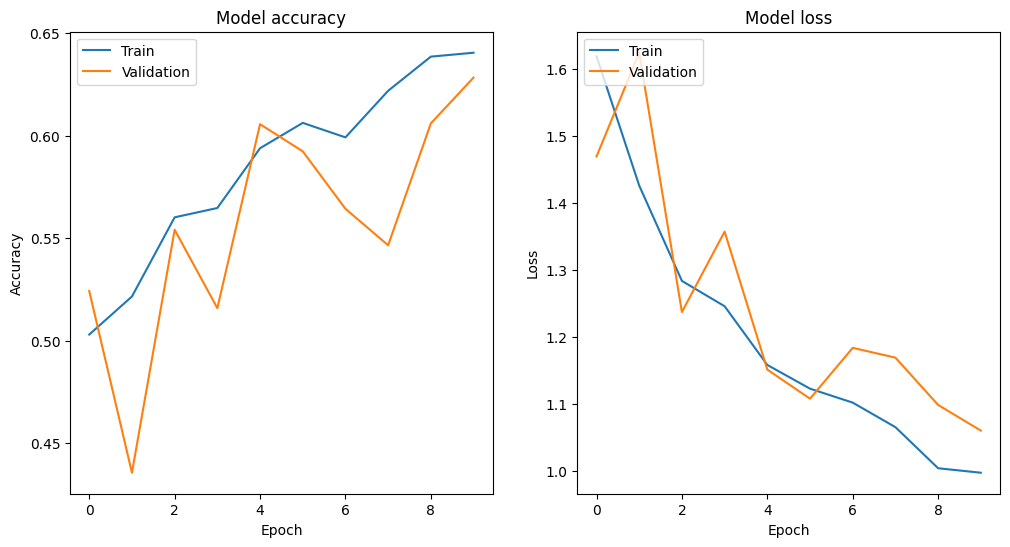

In [ ]:
plot_training_history(history)